# Tracing

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams["figure.figsize"] = [16, 10] 

In [2]:
def parse_trace(di, fix = 0):
    trace = pd.DataFrame(columns=["event", "id", "ts", "location"])
    for dirpath, dnames, fnames in os.walk(di):
        for f in fnames:
            if f.endswith(".csv"):
                t = pd.read_csv(os.path.join(dirpath, f), header=None, names=['event', 'id', 'ts'])
                t['location'] =  os.path.splitext(f)[0]
                trace = pd.concat([trace, t])
    trace = trace.set_index("id")
    return trace.apply(pd.to_numeric, errors='ignore')

In [3]:
def delay_between(trace, from_event, to_event, from_location = None, to_location = None):
    data = trace[(trace['event'] == from_event) | (trace['event'] == to_event)]
    joined = trace.join(trace, lsuffix='_from', rsuffix='_to', how='inner')
    filtered = joined[(joined['event_from'] == from_event) & (joined['event_to'] == to_event)]
    if from_location is not None:
        filtered = filtered[filtered['location_from'] == from_location]
    if to_location is not None:
        filtered = filtered[filtered['location_to'] == to_location]
    result = np.array((filtered['ts_to'] - filtered['ts_from']).unique(), dtype=np.int64)
    if len(result) < 500:
        print("There are " + str(len(result)) + " events from: '" + from_event + "', to: '" + to_event + ";")
    return result

In [4]:
def sync_skew(trace, from_event, to_event):
    for location in trace['location'].unique():
        d = delay_between(trace, from_event, to_event, from_location=location)
        if d.size > 0:
            min = d.min()
            trace.loc[trace['location'] == location, 'ts'] += min
    return trace

In [5]:
def read_data(filename):
    with open(filename) as f:
        d = np.array(f.read().strip().split(','), dtype=np.int64)
        return d[1000:] / 1e6

# Latencies

In [6]:
fs_w= {}
for workers in [10, 8, 6]:
    fs_w[workers] = read_data('data/bc21dbaf/' + str(workers) + '/70/flamestream/latency/lat.data')

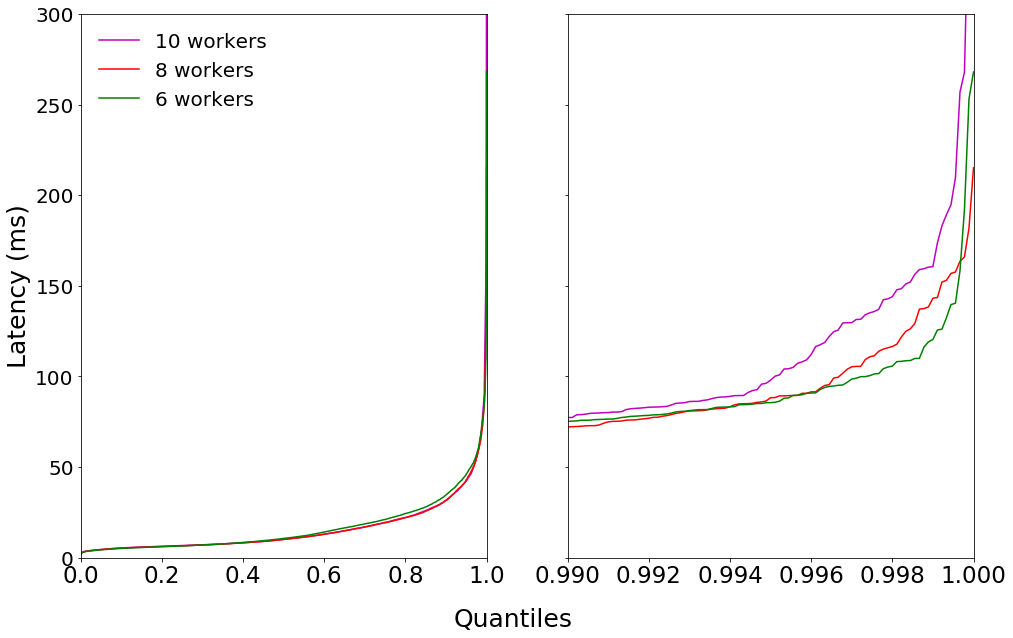

In [7]:
colors = {6 : 'g', 8 : 'r', 10 : 'm'}
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.set_xlim((.0, 1))
ax1.set_ylim((0, 300))

ax2.set_xlim((0.99, 1))

for workers, data in fs_w.items():
    ax1.plot(np.linspace(0, 1, len(data)), np.sort(data, axis=0), colors[workers], label=str(workers) + ' workers')
    ax2.plot(np.linspace(0, 1, len(data)), np.sort(data, axis=0), colors[workers], label=str(workers) + ' workers')
    
ax1.set_ylabel('Latency (ms)', fontsize=25)
fig.text(0.5, 0.04, 'Quantiles', fontsize=25, ha='center', va='center')
for tick in ax1.yaxis.get_major_ticks(): tick.label.set_fontsize(20)
for tick in ax1.xaxis.get_major_ticks(): tick.label.set_fontsize(23)
for tick in ax2.xaxis.get_major_ticks(): tick.label.set_fontsize(23)

ax1.legend(fontsize = 20, frameon=False, loc='upper left')
fig.savefig("../Papers/2017/distributed_runtime_for_analytical_stream_processing/pics/fs-index-quantiles.pdf", format='pdf', bbox_inches='tight')

In [8]:
fs = {}
fl = {}
for rate in [100, 50, 30, 20]:
    fs[rate] = read_data('data/51a914d6/10/' + str(rate) + '/flamestream/latency/lat.data')
    fl[rate] = read_data('data/51a914d6/10/' + str(rate) + '/flink/latency/lat.data')

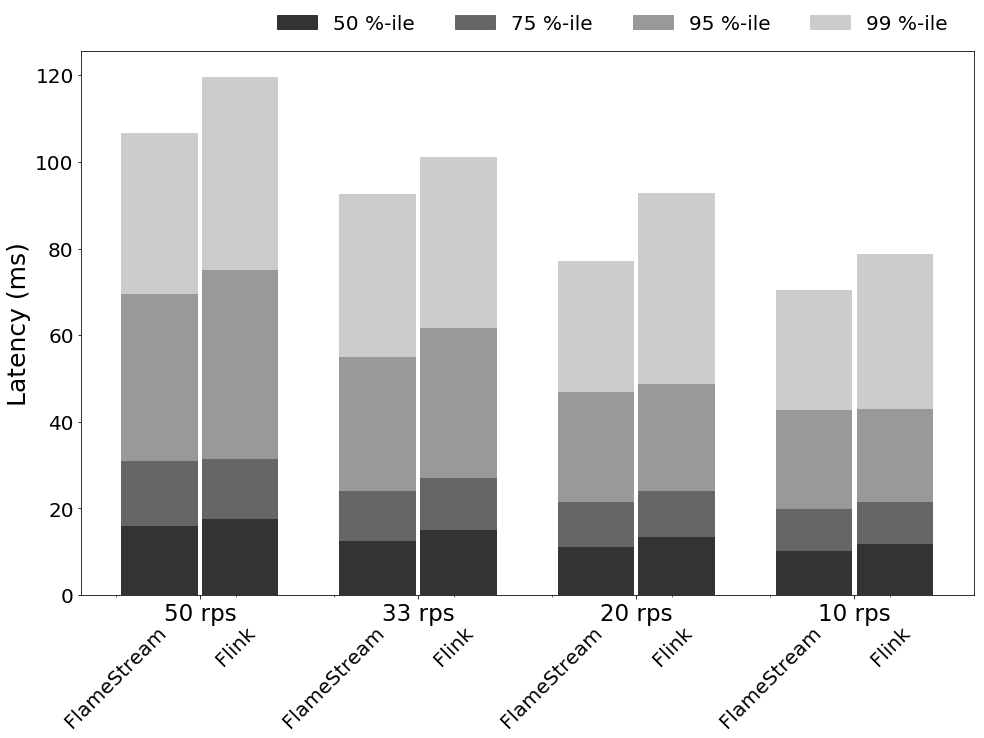

In [10]:
fig, ax = plt.subplots(frameon=False)

n = 4

ind = np.arange(1, n + 1)

fs_q = {}
fl_q = {}
w = .35
def do_plot(q, c):
    fs_q =  {rate: np.percentile(data, q) for rate, data in fs.items()}
    fl_q =  {rate: np.percentile(data, q) for rate, data in fl.items()}
    ax.bar(ind, [fs_q[20], fs_q[30],  fs_q[50], fs_q[100]], color=c, bottom = 0, width=w)
    ax.bar(ind + w + .02, [fl_q[20], fl_q[30], fl_q[50], fl_q[100]], color=c, bottom = 0, width=w)

do_plot(99, '.8')
do_plot(95, '.6')
do_plot(75, '.4')
do_plot(50, '.2')

ax.set_ylabel('Latency (ms)', fontsize=25)
for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(20) 
ax.set_xticks(np.concatenate((ind, ind + w + .2)) - .2, minor = True)
ax.set_xticklabels(['FlameStream'] * n + ['Flink'] * n, minor = True)
ax.tick_params(axis='x', which='minor', pad = 25)
    
rate_labels = tuple(map(lambda rate : str(1000 // rate) + ' rps', (20, 30, 50, 100)))
ax.set_xticks(ind + w / 2 + .01)
ax.set_xticklabels(rate_labels)

for tick in ax.xaxis.get_minor_ticks(): tick.label.set_fontsize(20); tick.label.set_rotation(45);
for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(23)

patch_99 = mpatches.Patch(color='.8', label='99 %-ile')
patch_95 = mpatches.Patch(color='.6', label='95 %-ile')
patch_75 = mpatches.Patch(color='.4', label='75 %-ile')
patch_50 = mpatches.Patch(color='.2', label='50 %-ile')
ax.legend(handles=[patch_99, patch_95, patch_75, patch_50][::-1], fontsize = 20, frameon=False, bbox_to_anchor=(0.2, 1), ncol=4)

#fig.savefig("../Papers/2017/distributed_runtime_for_analytical_stream_processing/pics/comp-index-quantiles.pdf", format='pdf', bbox_inches='tight')

In [11]:
fs_5 = {}
fl_5 = {}
for rate in [20, 30, 50, 100]:
    fs_5[rate] = read_data('data/51a914d6/5/' + str(rate) + '/flamestream/latency/lat.data')
    fl_5[rate] = read_data('data/51a914d6/5/' + str(rate) + '/flink/latency/lat.data')

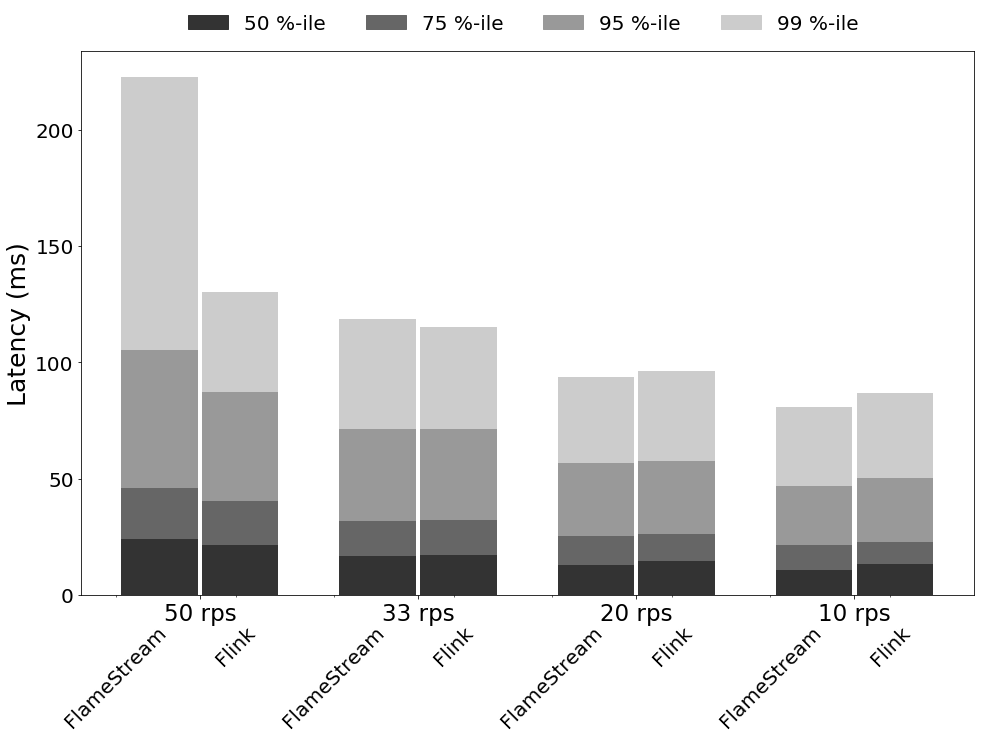

In [13]:
fig, ax = plt.subplots(frameon=False)

n = 4

ind = np.arange(1, n + 1)

fs_q = {}
fl_q = {}
w = .35
def do_plot(q, c):
    fs_q =  {rate: np.percentile(data, q) for rate, data in fs_5.items()}
    fl_q =  {rate: np.percentile(data, q) for rate, data in fl_5.items()}
    ax.bar(ind, [fs_q[20], fs_q[30],  fs_q[50], fs_q[100]], color=c, bottom = 0, width=w)
    ax.bar(ind + w + .02, [fl_q[20], fl_q[30], fl_q[50], fl_q[100]], color=c, bottom = 0, width=w)

do_plot(99, '.8')
do_plot(95, '.6')
do_plot(75, '.4')
do_plot(50, '.2')

#ax.set_ylim((0, 250))
ax.set_ylabel('Latency (ms)', fontsize=25)
for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(20) 
ax.set_xticks(np.concatenate((ind, ind + w + .2)) - .2, minor = True)
ax.set_xticklabels(['FlameStream'] * n + ['Flink'] * n, minor = True)
ax.tick_params(axis='x', which='minor', pad = 25)
    
rate_labels = tuple(map(lambda rate : str(1000 // rate) + ' rps', (20, 30, 50, 100)))
ax.set_xticks(ind + w / 2 + .01)
ax.set_xticklabels(rate_labels)

for tick in ax.xaxis.get_minor_ticks(): tick.label.set_fontsize(20); tick.label.set_rotation(45);
for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(23)

patch_99 = mpatches.Patch(color='.8', label='99 %-ile')
patch_95 = mpatches.Patch(color='.6', label='95 %-ile')
patch_75 = mpatches.Patch(color='.4', label='75 %-ile')
patch_50 = mpatches.Patch(color='.2', label='50 %-ile')
ax.legend(handles=[patch_99, patch_95, patch_75, patch_50][::-1], fontsize = 20, frameon=False, bbox_to_anchor=(0.1, 1), ncol=4)

#fig.savefig("../Papers/2017/distributed_runtime_for_analytical_stream_processing/pics/comp-index-quantiles_5.pdf", format='pdf', bbox_inches='tight')

# Tracing

In [14]:
def plot_fs_trace(trace):
    plt.xlim((0, 1))
    plt.ylim((0, 40))
    plt.xlabel("Quantile")
    plt.ylabel("Latency (ms)")

    bench_front = delay_between(trace, 'bench-send', 'front-receive-send') / 1e6
    plt.plot(np.linspace(0, 1, np.size(bench_front)), np.sort(bench_front), "r", label="bench - front (network)")

    to_source = delay_between(trace, 'front-receive-send', 'flatmap-receive') / 1e6
    to_source = to_source[to_source > 1]
    plt.plot(np.linspace(0, 1, np.size(to_source)), np.sort(to_source), "g", label="front - flatmap (shuffle)")
    part = delay_between(trace, 'fm-send', 'inject-in') / 1e6
    plt.plot(np.linspace(0, 1, np.size(part)), np.sort(part), "b", label="flatmap - grouping (shuffle)")

    rear_bench = delay_between(trace, 'rear-in', 'bench-receive') / 1e6
    plt.plot(np.linspace(0, 1, np.size(rear_bench)), np.sort(rear_bench), "m", label="rear - bench (network)")

    plt.legend(loc='upper left')

In [15]:
def plot_fl_trace(trace):
    plt.xlim((0, 1))
    plt.ylim((0, 40))
    plt.xlabel("Quantile")
    plt.ylabel("Latency (ms)")

    bench_front = delay_between(flink_trace, 'bench-send', 'source-receive') / 1e6
    plt.plot(np.linspace(0, 1, np.size(bench_front)), np.sort(bench_front), "r", label="bench - front (network)")

    source_fm = delay_between(flink_trace, 'source-receive', 'flatmap-receive') / 1e6
    plt.plot(np.linspace(0, 1, np.size(source_fm)), np.sort(source_fm), "g", label="front - flatmap (shuffle)")

    fm_enforcer = delay_between(flink_trace, 'flatmap-send', 'enforcer-receive') / 1e6
    plt.plot(np.linspace(0, 1, np.size(fm_enforcer)), np.sort(fm_enforcer), "b", label="flatmap - enforcer (shuffle)")

    a = delay_between(flink_trace, 'enforcer-receive', 'enforcer-send') / 1e6
    plt.plot(np.linspace(0, 1, np.size(a)), np.sort(a), "y", label="order enforcer")

    enforcer_sink = delay_between(flink_trace, 'enforcer-send', 'sink-receive') / 1e6
    plt.plot(np.linspace(0, 1, np.size(enforcer_sink)), np.sort(enforcer_sink), label="enforcer - sink")

    sink_bench = delay_between(flink_trace, 'sink-receive', 'bench-receive') / 1e6
    plt.plot(np.linspace(0, 1, np.size(sink_bench)), np.sort(sink_bench), "m", label="sink - bench (network)")

    plt.legend(loc='upper left')


In [16]:
trace = sync_skew(parse_trace("data/bc21dbaf/10/70/flamestream/traces"), 'rear-in', 'bench-receive')
start = trace['ts'].min() + 200 * (100 * 1e6)
trace = trace[trace['ts'] > start]
trace.shape

There are 0 events from: 'rear-in', to: 'bench-receive;
There are 0 events from: 'rear-in', to: 'bench-receive;
There are 0 events from: 'rear-in', to: 'bench-receive;
There are 0 events from: 'rear-in', to: 'bench-receive;
There are 0 events from: 'rear-in', to: 'bench-receive;
There are 0 events from: 'rear-in', to: 'bench-receive;
There are 0 events from: 'rear-in', to: 'bench-receive;
There are 0 events from: 'rear-in', to: 'bench-receive;
There are 0 events from: 'rear-in', to: 'bench-receive;


(96659, 3)

In [17]:
flink_trace = parse_trace("data/bc21dbaf/10/70/flink/traces")
start = flink_trace['ts'].min() + 200 * (100 * 1e6)
flink_trace = flink_trace[flink_trace['ts'] > start]
flink_trace.shape

(253266, 3)

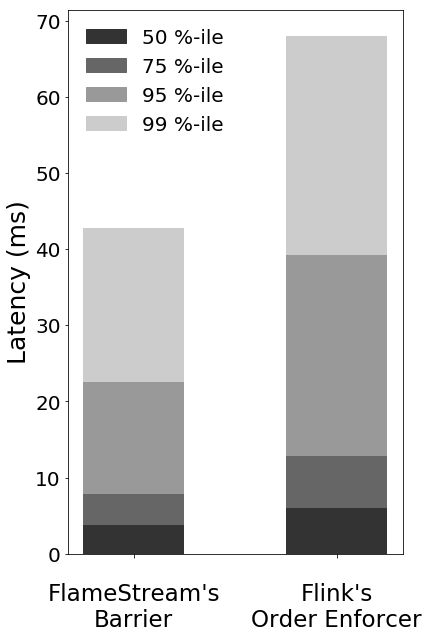

In [18]:
barrier = delay_between(trace, 'sink-receive', 'sink-send') / 1e6
enforcer =  delay_between(flink_trace, 'enforcer-receive', 'enforcer-send') / 1e6

fig, ax = plt.subplots(figsize=(6,10))
ind = np.arange(1, 3)
w = .5
def do_plot(q, c):
    fs_q = np.percentile(barrier, q)
    fl_q = np.percentile(enforcer, q)
    ax.bar(ind, [fs_q, fl_q], color=c, bottom = 0, width=w)

do_plot(99, '.8')
do_plot(95, '.6')
do_plot(75, '.4')
do_plot(50, '.2')

ax.set_ylabel('Latency (ms)', fontsize=25)
for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(20)

ax.set_xticks(ind)
ax.set_xticklabels(['FlameStream\'s\nBarrier', 'Flink\'s\nOrder Enforcer'])
for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(23)

patch_99 = mpatches.Patch(color='.8', label='99 %-ile')
patch_95 = mpatches.Patch(color='.6', label='95 %-ile')
patch_75 = mpatches.Patch(color='.4', label='75 %-ile')
patch_50 = mpatches.Patch(color='.2', label='50 %-ile')
ax.legend(handles=[patch_99, patch_95, patch_75, patch_50][::-1], fontsize = 20, frameon=False, ncol=1)
ax.tick_params(axis='x', pad = 25)

fig.savefig("../Papers/2017/distributed_runtime_for_analytical_stream_processing/pics/buffer-vs-barrier.pdf", format='pdf', bbox_inches='tight')

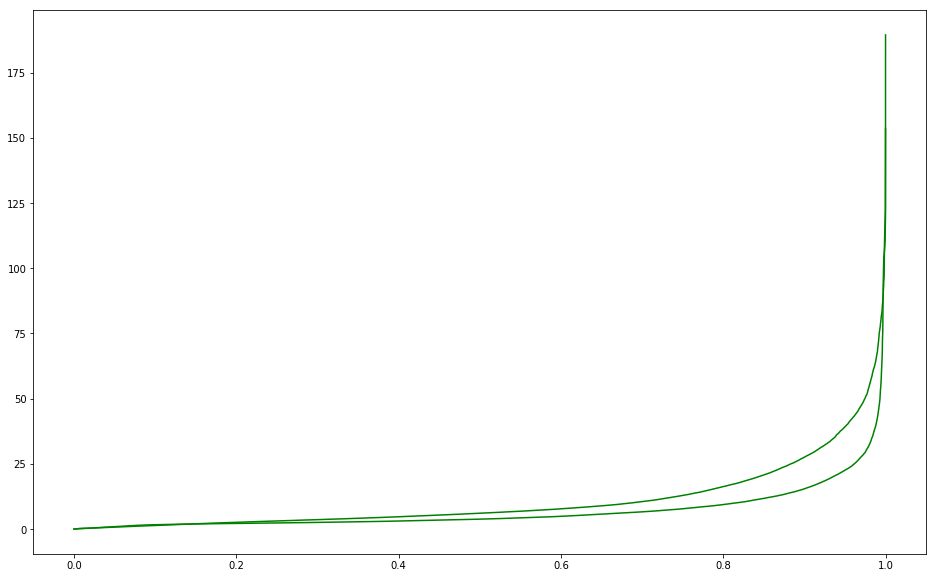

In [19]:
plt.plot(np.linspace(0, 1, np.size(barrier)), np.sort(barrier), "g", label="front - flatmap (shuffle)")
plt.plot(np.linspace(0, 1, np.size(enforcer)), np.sort(enforcer), "g", label="front - flatmap (shuffle)")

There are 0 events from: 'bench-send', to: 'front-receive-send;
There are 0 events from: 'front-receive-send', to: 'flatmap-receive;
There are 0 events from: 'fm-send', to: 'inject-in;
There are 0 events from: 'rear-in', to: 'bench-receive;


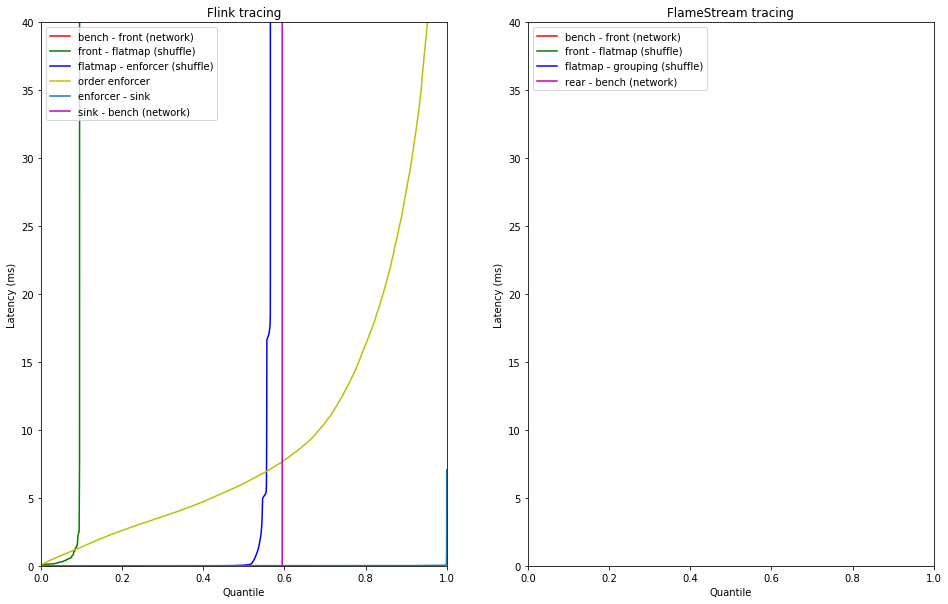

In [20]:
plt.subplot(1, 2, 1)
plt.title("Flink tracing")
plot_fl_trace(flink_trace)

plt.subplot(1, 2, 2)
plt.title("FlameStream tracing")
plot_fs_trace(trace)

plt.show()